In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-video/CSE-Math4641-Lecture11(Recording Part-2).mkv


In [13]:
# ==============================================================
# Hybrid Keyframe Extractor for Lecture Videos (Entropy + OCR + CLIP)
# ==============================================================

import cv2, torch, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sentence_transformers import SentenceTransformer, util
import pytesseract
import gc, os

# -----------------------------
# 1️⃣ Locate first video
# -----------------------------
VIDEO_PATH = "/kaggle/input/test-video/CSE-Math4641-Lecture18(Recording)2.mkv"
print("Using video:", VIDEO_PATH)

# -----------------------------
# 2️⃣ Output setup
# -----------------------------
OUTPUT_DIR = Path("/kaggle/working/keyframes")
(OUTPUT_DIR / "frames").mkdir(parents=True, exist_ok=True)

# -----------------------------
# 3️⃣ Config
# -----------------------------
TARGET_FPS = 1.0
MAX_FRAMES = 4000
TOP_K = 120
MIN_SEC_GAP = 1.5
MAX_SIM_WITH_SELECTED = 0.98
DOWNSCALE = (480, 270)

ALPHA, BETA, GAMMA = 0.4, 0.3, 0.3  # weights for entropy, text, semantic

# -----------------------------
# 4️⃣ Utility functions
# -----------------------------
def shannon_entropy(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray],[0],None,[256],[0,256]).ravel()
    p = hist / gray.size
    p = p[p>0]
    return float(-(p*np.log2(p)).sum())

def mser_text_regions(gray):
    if len(gray.shape)==3: gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
    mser = cv2.MSER_create(5, 60, 5000)
    regions,_ = mser.detectRegions(gray)
    count = len(regions)
    area = sum(cv2.contourArea(cv2.convexHull(r.reshape(-1,1,2))) for r in regions)
    ratio = area / max(1, gray.size)
    return count + 10*ratio

def quick_text_density(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    proxy = mser_text_regions(gray)
    try:
        txt = pytesseract.image_to_string(gray)
        proxy += len(txt.strip())
    except Exception:
        pass
    return proxy

# -----------------------------
# 5️⃣ Fast sampling
# -----------------------------
def sample_frames(video_path, target_fps=1.0, max_frames=4000):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    duration = total / fps
    interval = 1000.0 / target_fps
    frames, times = [], []
    t = 0.0
    while t < duration*1000 and len(frames)<max_frames:
        cap.set(cv2.CAP_PROP_POS_MSEC, t)
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.resize(frame, DOWNSCALE)
        frames.append(frame)
        times.append(t/1000.0)
        t += interval
    cap.release()
    print(f"[INFO] Sampled {len(frames)} frames over {duration:.1f}s")
    return frames, times

# -----------------------------
# 6️⃣ CLIP model
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = SentenceTransformer("clip-ViT-B-32", device=device)
print(f"[INFO] CLIP model on {device}")

# -----------------------------
# 7️⃣ Scoring
# -----------------------------
# from PIL import Image

# def to_pil_rgb(img_bgr):
#     return Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

# def score_frames(frames, times):
#     results=[]
#     prev_emb=None
#     pil_frames = [to_pil_rgb(f) for f in frames]

#     with torch.no_grad():
#         embeddings = clip_model.encode(
#             pil_frames,
#             batch_size=32,
#             convert_to_tensor=True,
#             device=device,
#             normalize_embeddings=True,
#             show_progress_bar=True
#         )

#     for i,(img,t) in enumerate(zip(frames,times)):
#         ent = shannon_entropy(img)
#         txt = quick_text_density(img)
#         sim = util.cos_sim(embeddings[i], embeddings[i-1]).item() if i>0 else 0
#         score = ALPHA*ent + BETA*txt + GAMMA*(1-sim)
#         results.append(dict(index=i, timestamp=t, entropy=ent, text_density=txt, sim_prev=sim, score=score))
#     return results, embeddings

from skimage.metrics import structural_similarity as ssim
from PIL import Image

def to_pil_rgb(img_bgr):
    return Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

def score_frames(frames, times):
    results=[]
    pil_frames = [to_pil_rgb(f) for f in frames]

    # CLIP embeddings (semantic)
    with torch.no_grad():
        embeddings = clip_model.encode(
            pil_frames, batch_size=32,
            convert_to_tensor=True, device=device,
            normalize_embeddings=True, show_progress_bar=True
        )

    for i, (img, t) in enumerate(zip(frames, times)):
        ent = shannon_entropy(img)
        txt = quick_text_density(img)

        # global semantic similarity
        sim_clip = util.cos_sim(embeddings[i], embeddings[i-1]).item() if i > 0 else 0.0

        # local structure similarity (grayscale)
        sim_ssim = 0.0
        if i > 0:
            gray_now = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray_prev = cv2.cvtColor(frames[i-1], cv2.COLOR_BGR2GRAY)
            sim_ssim = ssim(gray_now, gray_prev)

        # hybrid score
        score = (
            0.35 * ent +
            0.25 * txt +
            0.25 * (1 - sim_clip) +
            0.15 * (1 - sim_ssim)
        )

        results.append(dict(
            index=i, timestamp=t,
            entropy=ent, text_density=txt,
            sim_clip=sim_clip, sim_ssim=sim_ssim,
            score=score
        ))

    return results, embeddings


# -----------------------------
# 8️⃣ Diversity selection
# -----------------------------
def select_diverse_clip(results, embeddings, top_k=60, min_gap=1.5, max_sim=0.98):
    order = sorted(range(len(results)), key=lambda i: results[i]['score'], reverse=True)
    chosen=[]
    chosen_ts=[]
    for idx in order:
        if len(chosen)>=top_k: break
        ts = results[idx]['timestamp']
        if any(abs(ts - results[j]['timestamp']) < min_gap for j in chosen):
            continue
        emb = embeddings[idx]
        too_sim=False
        for j in chosen:
            sim = util.cos_sim(emb, embeddings[j]).item()
            if sim > max_sim:
                too_sim=True; break
        if too_sim: continue
        chosen.append(idx); chosen_ts.append(ts)
    chosen.sort(key=lambda i: results[i]['timestamp'])
    return chosen

# -----------------------------
# 9️⃣ Run pipeline
# -----------------------------
frames,times = sample_frames(VIDEO_PATH, TARGET_FPS, MAX_FRAMES)
results, embeddings = score_frames(frames,times)
df = pd.DataFrame(results)
chosen = select_diverse_clip(results, embeddings, TOP_K, MIN_SEC_GAP, MAX_SIM_WITH_SELECTED)
print(f"[INFO] Selected {len(chosen)} keyframes.")

# -----------------------------
# 🔟 Save outputs
# -----------------------------
outdir = OUTPUT_DIR/"frames"
outdir.mkdir(parents=True, exist_ok=True)
rows=[]
for r,idx in enumerate(chosen):
    t=results[idx]['timestamp']
    name=f"frame_{r:03d}_t{t:.1f}.jpg"
    cv2.imwrite(str(outdir/name), frames[idx])
    row=results[idx].copy(); row.update({"file":name,"rank":r})
    rows.append(row)
manifest=pd.DataFrame(rows)
manifest.to_csv(OUTPUT_DIR/"keyframes_manifest.csv", index=False)
print(f"[INFO] Saved {len(manifest)} frames to:", outdir)

# -----------------------------
# 🔍 Diagnostics
# -----------------------------
plt.figure(figsize=(10,4))
plt.scatter(df["timestamp"], df["score"], s=8)
plt.xlabel("Time (s)"); plt.ylabel("Score"); plt.title("Frame Score vs Time")
plt.tight_layout(); plt.savefig(OUTPUT_DIR/"scores_plot.png", dpi=150); plt.close()
print("[INFO] Saved plot:", OUTPUT_DIR/"scores_plot.png")

print("✅ Done.")


Using video: /kaggle/input/test-video/CSE-Math4641-Lecture18(Recording)2.mkv
[INFO] CLIP model on cuda
[INFO] Sampled 460 frames over 459.1s


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

[INFO] Selected 28 keyframes.
[INFO] Saved 28 frames to: /kaggle/working/keyframes/frames
[INFO] Saved plot: /kaggle/working/keyframes/scores_plot.png
✅ Done.


In [14]:
import cv2
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from pathlib import Path

manifest_path = OUTPUT_DIR / "keyframes_manifest.csv"
manifest = pd.read_csv(manifest_path)
frames = [cv2.imread(str(OUTPUT_DIR / "frames" / f)) for f in manifest["file"]]

# --- Text density helper ---
def handwriting_density(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # use MSER + edge density as proxy for handwriting area
    mser = cv2.MSER_create()
    regions, _ = mser.detectRegions(gray)
    mser_area = sum(cv2.contourArea(cv2.convexHull(r.reshape(-1,1,2))) for r in regions)
    edges = cv2.Canny(gray, 80, 180)
    edge_density = edges.sum() / (255 * gray.size)
    return mser_area / gray.size + 3 * edge_density  # weighted mix

# --- Similarity metric ---
def frame_similarity(a, b):
    grayA = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
    return ssim(grayA, grayB)

# --- Group similar frames and choose best ---
clusters = []
used = set()
SSIM_THRESH = 0.9

for i in range(len(frames)):
    if i in used: 
        continue
    cluster = [i]
    used.add(i)
    for j in range(i+1, len(frames)):
        if j in used:
            continue
        if frame_similarity(frames[i], frames[j]) > SSIM_THRESH:
            cluster.append(j)
            used.add(j)
    clusters.append(cluster)

print(f"[INFO] Formed {len(clusters)} visual clusters")

# --- Select one frame per cluster ---
chosen_idx = []
for cluster in clusters:
    best_idx = max(cluster, key=lambda k: handwriting_density(frames[k]))
    chosen_idx.append(best_idx)

print(f"[INFO] Reduced {len(frames)} → {len(chosen_idx)} by handwriting density filtering")

# --- Save filtered manifest ---
filtered = manifest.iloc[sorted(chosen_idx)]
filtered.to_csv(OUTPUT_DIR / "keyframes_manifest_filtered.csv", index=False)


[INFO] Formed 7 visual clusters
[INFO] Reduced 28 → 7 by handwriting density filtering


In [15]:
import shutil
from IPython.display import display, Image as IPImage
import matplotlib.pyplot as plt
import math

# Load the filtered manifest
filtered_path = OUTPUT_DIR / "keyframes_manifest_filtered.csv"
filtered = pd.read_csv(filtered_path)

# Overwrite the original manifest
filtered.to_csv(OUTPUT_DIR / "keyframes_manifest.csv", index=False)
print(f"[INFO] Overwritten manifest with {len(filtered)} final frames")

# Clean old frames folder and copy only final ones
final_outdir = OUTPUT_DIR / "frames_final"
if final_outdir.exists():
    shutil.rmtree(final_outdir)
final_outdir.mkdir(parents=True, exist_ok=True)

for f in filtered["file"]:
    src = OUTPUT_DIR / "frames" / f
    dst = final_outdir / f
    shutil.copy2(src, dst)

print(f"[INFO] Saved {len(filtered)} final frames to:", final_outdir)


[INFO] Overwritten manifest with 7 final frames
[INFO] Saved 7 final frames to: /kaggle/working/keyframes/frames_final


▶ frame_000_t0.0.jpg


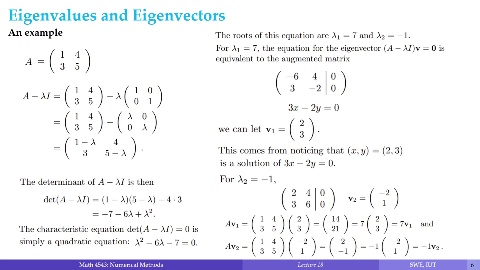

▶ frame_001_t5.0.jpg


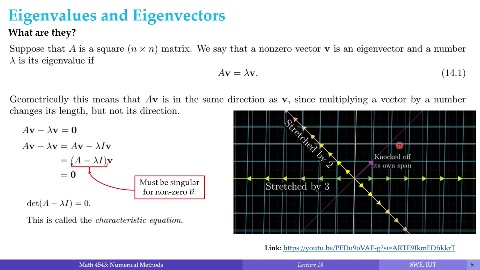

▶ frame_002_t15.0.jpg


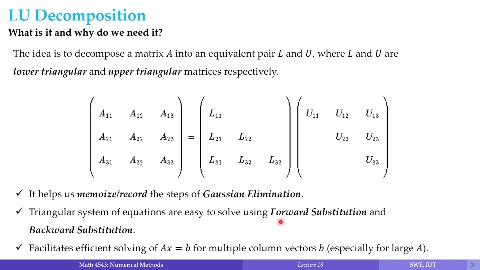

▶ frame_003_t35.0.jpg


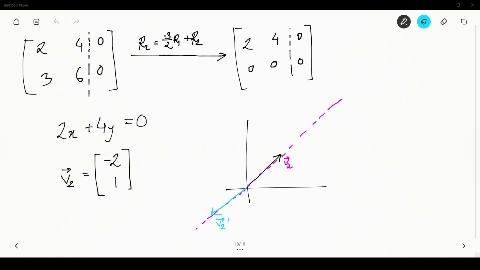

▶ frame_004_t100.0.jpg


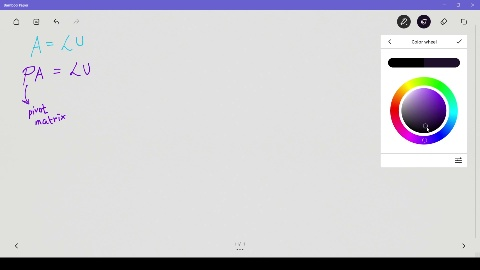

▶ frame_026_t435.0.jpg


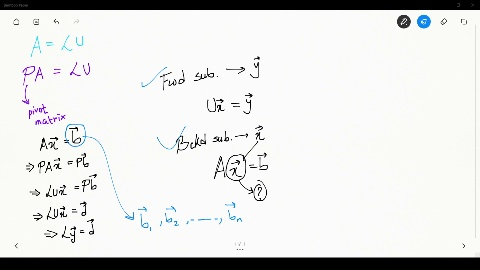

▶ frame_027_t450.0.jpg


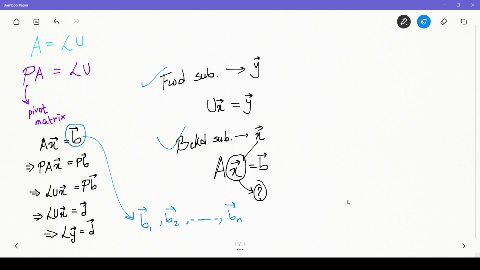

In [16]:
for f in sorted(final_outdir.glob("*.jpg")):
    print(f"▶ {f.name}")
    display(IPImage(filename=f))
